# Linear Mixed Effects Modeling

## Identify which are the best factors that can aid in prediction of mass removal
## What are the best substitutes for them?

In [14]:
#import libraries
import os
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
import statsmodels.formula.api as smf
import matplotlib.pyplot as plt

In [ ]:
## Define functions to calculate RMSE and AIC

In [66]:
def calculate_rmse (y_pred, y_true):
    rmse = np.sqrt(((y_true-y_pred)**2).mean())
    return rmse

def calculate_aic(n, mse, num_params):
    aic = n * log(mse) + 2 * num_params
    return aic

## Data directory and file sources

In [3]:
data_dir = "Y:/Home/khurana/4. Publications/Restructuring/Paper1/Figurecodes/"
data_file = "Da_29012021_95pcloss.csv"

## Load data

In [111]:
#head_data = pd.read_csv(os.path.join(data_dir, head_path), sep = ",")
#RMSamp_data = pd.read_csv(os.path.join(data_dir, RMSamp_path), sep = "\t")
#sensitivity_data = pd.read_csv(os.path.join(data_dir, sensitivity_path), sep = "\t")
da_data = pd.read_csv(os.path.join(data_dir, data_file), sep = ",")

In [112]:
da_data.columns

Index(['Unnamed: 0', 'Regime', 'Velocity', 'Pe', 'Trial', 'Chem', 'Conc_in',
       'Conc_out', 'Normconc', 'base', 'rel_normconc', 'Variance',
       'Anisotropy', 'Domain', 'Time_series', 'massflux_in', 'massflux_out',
       'delmassflux', 'reldelmassflux', 'normmassflux', 'Time', 'fraction',
       'temporal_normmassflux_base', 'spatial_normmassflux_base',
       'temporal_reldelmassflux_base', 'spatial_reldelmassflux_base',
       'normmassflux_temporal_fraction', 'normmassflux_spatial_fraction',
       'reldelmassflux_temporal_fraction', 'reldelmassflux_spatial_fraction',
       'Da63', 'k', 'tau63'],
      dtype='object')

## Manipulate the dataset to include chemicals as numeric factors and calculate transformed Damkohler number and the category of the regime

In [113]:
cleanup_tim = {"chem_factors" : {'DOC':0,'DO':1, 'Ammonium':2, 'Nitrate':3, 'Sulphate':4, 'Particulate organic matter':5,
                                 'Mobile active aerobic degraders':6, 'Mobile active nitrate reducers':7,
                                 'Mobile active sulphate reducers':8, 'Mobile active ammonia oxidizers':9,
                                 'Mobile inactive aerobic degraders':10, 'Mobile inactive nitrate reducers':11,
                                 'Mobile inactive sulphate reducers':12, 'Mobile inactive ammonia oxidizers':13,
                                 'Nitrogen':14, 'TOC':15}}

da_data["chem_factors"] = da_data ["Chem"]
da_data.replace(cleanup_tim, inplace = True)

da_data["logDaPe"] = np.log(da_data.Da63/da_data.Pe)

print(da_data.logDaPe.min())
print(da_data.logDaPe.mean())
print(da_data.logDaPe.max())

-7.5572376210508985
-2.7619350274769903
5.098136044009284


In [114]:
da_data.loc[da_data["logDaPe"] > 0, "PeDamark"] = 3
da_data.loc[(da_data["logDaPe"] > -2) & (da_data["logDaPe"] < 0), "PeDamark"] = 2
da_data.loc[(da_data["logDaPe"] > -6) & (da_data["logDaPe"] < -2), "PeDamark"] = 1
da_data.loc[(da_data["logDaPe"] < -6), "PeDamark"] = 0
labels = {3 : "ln(Da/Pe) > 0",
          2 : "-2 < ln(Da/Pe) < 0",
          1 : "-6 < ln(Da/Pe) < -2",
         0 : "ln(Da/Pe) < -6"}
print(da_data.PeDamark.unique().tolist())

[2.0, 3.0, 1.0, 0.0]


## List features that you want to test for modeling

In [115]:
features = ['Variance', 'Anisotropy', 'Regime', 'Chem', 'Time', 'fraction', 'logDaPe', 'PeDamark']
yfeature = ['reldelmassflux', 'reldelmassflux_spatial_fraction', 'normmassflux', 'normmassflux_spatial_fraction']

mydata = da_data[features+yfeature]
chemstoplot = ["DOC", "DO", "Nitrogen", "TOC"]
mydata = mydata[mydata['Chem'].isin (chemstoplot)]
mydata["Variance"]= mydata["Variance"].astype(str)
mydata["Anisotropy"]= mydata["Anisotropy"].astype(str)

## Visualize

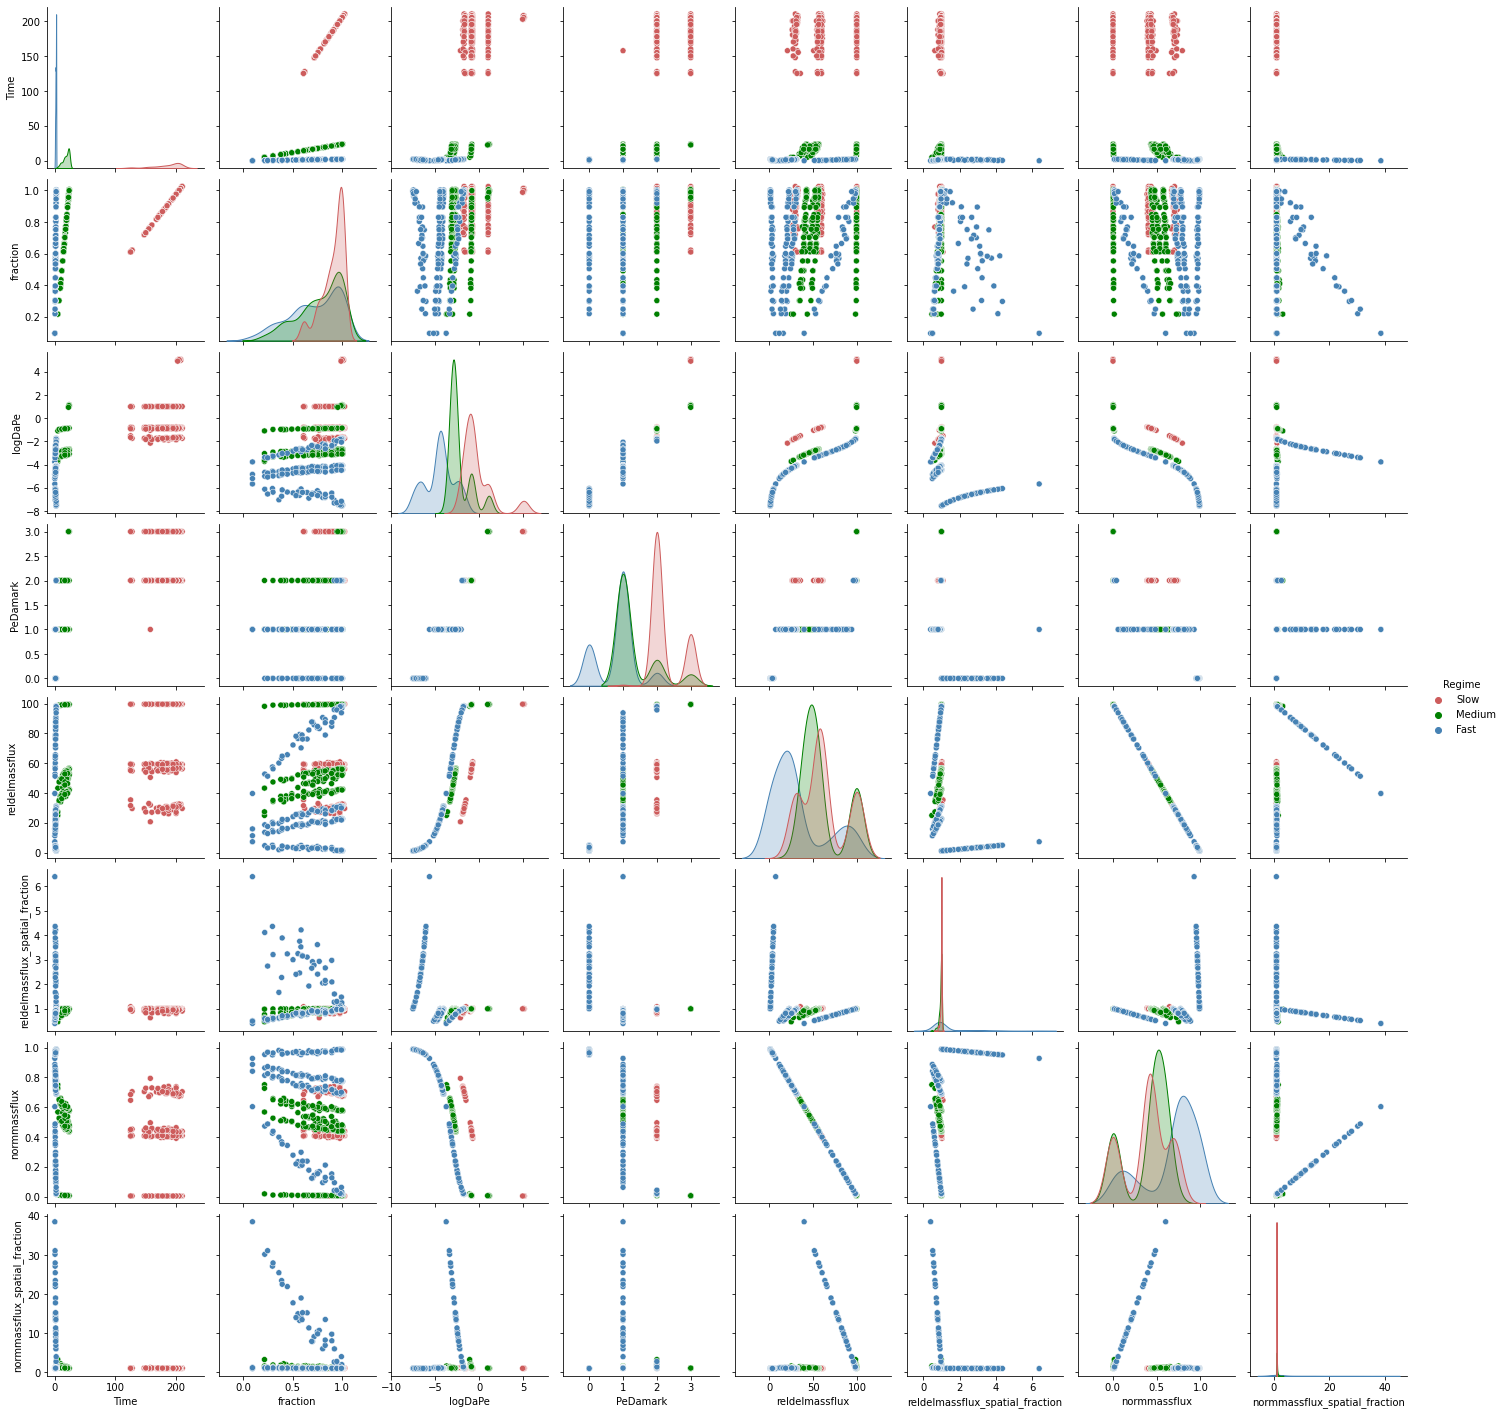

In [116]:
colsymdict = {"Slow" : "indianred", "Medium" : "g", "Fast" : "steelblue",
              "DOC": 'D', "DO" : '^', "Nitrogen" : 's', "TOC" : 'o'}

#Plot yfeature with breakthrough time divided by regime, variance and anisotropy
import seaborn as sns
sns.pairplot(mydata, kind="scatter", hue="Regime", palette=colsymdict)

## Explore with features

In [117]:
mydata["R_V_A"] = mydata["Regime"] + "_" + mydata["Variance"].astype(str) + "_" + mydata["Anisotropy"].astype(str)
mydata["V_A_C"] = mydata["Variance"].astype(str) + "_" + mydata["Anisotropy"].astype(str) + "_" + mydata["Chem"]
mydata["R_V_A_C"] = mydata["Regime"] + "_" + mydata["Variance"].astype(str) + "_" + mydata["Anisotropy"].astype(str) + "_" + mydata["Chem"]
mydata ["R_C"] = mydata["Regime"] + "_" + mydata["Chem"]

In [119]:
#Considering only fixed effects = Simple regression
xplot = 'fraction'
yplot = 'reldelmassflux_spatial_fraction'
y = mydata[yplot]

f1 = yplot + ' ~ ' + xplot
f2 = yplot + '~' + 'fraction + Regime'
f3 = yplot + '~' + 'fraction + Regime + Chem'
f4 = yplot + '~' + 'fraction + Chem'

In [120]:
dm1 = smf.mixedlm(formula = forms, data = mydata, groups = 'Regime')
dm1f = dm1.fit(reml = False)

dm2 = smf.mixedlm(formula = forms, data = mydata, groups = 'Chem')
dm2f = dm2.fit(reml = False)

dm3 = smf.mixedlm(formula = forms, data = mydata, groups = 'Regime', re_formula = '~' + xplot)
dm3f = dm3.fit(reml = False)

dm4 = smf.mixedlm(formula = f1, data = mydata, groups = 'Chem', re_formula = '~' + xplot)
dm4f = dm4.fit(reml = False)

dm5 = smf.mixedlm(formula = f1, data = mydata, groups = 'logDaPe')
dm5f = dm5.fit(reml = False)

dm6 = smf.mixedlm(formula = f1, data = mydata, groups = 'logDaPe', re_formula = '~' + xplot)
dm6f = dm6.fit(reml = False)

dm7 = smf.mixedlm(formula = f1, data = mydata, groups = 'PeDamark')
dm7f = dm7.fit(reml = False)

dm8 = smf.mixedlm(formula = f1, data = mydata, groups = 'PeDamark', re_formula = '~' + xplot)
dm8f = dm8.fit(reml = False)

dm9 = smf.mixedlm(formula = f1, data = mydata, groups = 'V_A_C')
dm9f = dm9.fit(reml = False)

dm10 = smf.mixedlm(formula = f1, data = mydata, groups = 'V_A_C', re_formula = '~' + xplot)
dm10f = dm10.fit(reml = False)

dm11 = smf.mixedlm(formula = f1, data = mydata, groups = 'R_V_A_C')
dm11f = dm11.fit(reml = False)

dm12 = smf.mixedlm(formula = f1, data = mydata, groups = 'R_V_A_C', re_formula = '~' + xplot)
dm12f = dm12.fit(reml = False)

dm13 = smf.mixedlm(formula = f1, data = mydata, groups = 'R_C')
dm13f = dm13.fit(reml = False)

dm14 = smf.mixedlm(formula = f1, data = mydata, groups = 'R_C', re_formula = '~' + xplot)
dm14f = dm14.fit(reml = False)

dm15 = smf.mixedlm(formula = f1, data = mydata, groups = 'R_V_A')
dm15f = dm15.fit(reml = False)

dm16 = smf.mixedlm(formula = f1, data = mydata, groups = 'R_V_A', re_formula = '~' + xplot)
dm16f = dm16.fit(reml = False)

for i, model in zip(range(16), [dm1f, dm2f,dm3f,dm4f,dm5f,dm6f,dm7f,dm8f, dm9f,dm10f,dm11f,dm12f,dm13f,dm14f, dm15f, dm16f]):
    print(i+1, model.aic)

C:\Users\khurana\Anaconda3\envs\mlsm\lib\site-packages\statsmodels\regression\mixed_linear_model.py:1634: UserWarning: Random effects covariance is singular
  warnings.warn(msg)
C:\Users\khurana\Anaconda3\envs\mlsm\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\khurana\Anaconda3\envs\mlsm\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2200: ConvergenceWarning: Retrying MixedLM optimization with lbfgs
  warnings.warn(
C:\Users\khurana\Anaconda3\envs\mlsm\lib\site-packages\statsmodels\regression\mixed_linear_model.py:1634: UserWarning: Random effects covariance is singular
  warnings.warn(msg)
C:\Users\khurana\Anaconda3\envs\mlsm\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimizatio

KeyboardInterrupt: 

### Checking formulae one at a time

In [121]:
for forms,idx in zip([f1,f2,f3,f4], range (4)):
    print ("f"+str(idx+1))
    dm1 = smf.mixedlm(formula = forms, data = mydata, groups = 'Regime')
    dm1f = dm1.fit(reml = False)
    
    dm2 = smf.mixedlm(formula = forms, data = mydata, groups = 'Chem')
    dm2f = dm2.fit(reml = False)
    
    dm3 = smf.mixedlm(formula = forms, data = mydata, groups = 'Regime', re_formula = '~' + xplot)
    dm3f = dm3.fit(reml = False)
    
    dm4 = smf.mixedlm(formula = forms, data = mydata, groups = 'Chem', re_formula = '~' + xplot)
    dm4f = dm4.fit(reml = False)
    
    dm5 = smf.mixedlm(formula = forms, data = mydata, groups = 'logDaPe')
    dm5f = dm5.fit(reml = False)
    
    dm6 = smf.mixedlm(formula = forms, data = mydata, groups = 'logDaPe', re_formula = '~' + xplot)
    dm6f = dm6.fit(reml = False)
    
    dm7 = smf.mixedlm(formula = forms, data = mydata, groups = 'PeDamark')
    dm7f = dm7.fit(reml = False)
    
    dm8 = smf.mixedlm(formula = forms, data = mydata, groups = 'PeDamark', re_formula = '~' + xplot)
    dm8f = dm8.fit(reml = False)
    
    dm9 = smf.mixedlm(formula = forms, data = mydata, groups = 'V_A_C')
    dm9f = dm9.fit(reml = False)
    
    dm10 = smf.mixedlm(formula = forms, data = mydata, groups = 'V_A_C', re_formula = '~' + xplot)
    dm10f = dm10.fit(reml = False)
    
    dm11 = smf.mixedlm(formula = forms, data = mydata, groups = 'R_V_A_C')
    dm11f = dm11.fit(reml = False)
    
    dm12 = smf.mixedlm(formula = forms, data = mydata, groups = 'R_V_A_C', re_formula = '~' + xplot)
    dm12f = dm12.fit(reml = False)
    
    dm13 = smf.mixedlm(formula = forms, data = mydata, groups = 'R_C')
    dm13f = dm13.fit(reml = False)
    
    dm14 = smf.mixedlm(formula = forms, data = mydata, groups = 'R_C', re_formula = '~' + xplot)
    dm14f = dm14.fit(reml = False)
    
    dm15 = smf.mixedlm(formula = forms, data = mydata, groups = 'R_V_A')
    dm15f = dm15.fit(reml = False)
    
    dm16 = smf.mixedlm(formula = forms, data = mydata, groups = 'R_V_A', re_formula = '~' + xplot)
    dm16f = dm16.fit(reml = False)
    
    for i, model in zip(range(16), [dm1f, dm2f,dm3f,dm4f,dm5f,dm6f,dm7f,dm8f, dm9f,dm10f,dm11f,dm12f,dm13f,dm14f, dm15f, dm16f]):
        print(i+1, model.aic)

f1


C:\Users\khurana\Anaconda3\envs\mlsm\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\khurana\Anaconda3\envs\mlsm\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2200: ConvergenceWarning: Retrying MixedLM optimization with lbfgs
  warnings.warn(
C:\Users\khurana\Anaconda3\envs\mlsm\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2261: ConvergenceWarning: The Hessian matrix at the estimated parameter values is not positive definite.
  warnings.warn(msg, ConvergenceWarning)
C:\Users\khurana\Anaconda3\envs\mlsm\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\khurana\Anaconda3\envs\mlsm\lib\site-packages\statsmodels\regression\mixed_linear_model

C:\Users\khurana\Anaconda3\envs\mlsm\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\khurana\Anaconda3\envs\mlsm\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2200: ConvergenceWarning: Retrying MixedLM optimization with lbfgs
  warnings.warn(
C:\Users\khurana\Anaconda3\envs\mlsm\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\khurana\Anaconda3\envs\mlsm\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2200: ConvergenceWarning: Retrying MixedLM optimization with cg
  warnings.warn(
C:\Users\khurana\Anaconda3\envs\mlsm\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Che

1 904.8806765068093
2 841.0521359768181
3 896.2139662428572
4 677.2947433517074
5 925.7021588156158
6 445.7014348438206
7 551.9965834130153
8 295.34814007032674
9 879.2368655897726
10 755.3370986403206
11 426.5363634745745
12 156.45860604355948
13 481.84088358646295
14 -147.754090403605
15 926.3593904145227
16 925.9737484563993
f2


C:\Users\khurana\Anaconda3\envs\mlsm\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\khurana\Anaconda3\envs\mlsm\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2200: ConvergenceWarning: Retrying MixedLM optimization with lbfgs
  warnings.warn(
C:\Users\khurana\Anaconda3\envs\mlsm\lib\site-packages\statsmodels\regression\mixed_linear_model.py:1634: UserWarning: Random effects covariance is singular
  warnings.warn(msg)
C:\Users\khurana\Anaconda3\envs\mlsm\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2054: UserWarning: The random effects covariance matrix is singular.
  warnings.warn(_warn_cov_sing)
C:\Users\khurana\Anaconda3\envs\mlsm\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg

C:\Users\khurana\Anaconda3\envs\mlsm\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\khurana\Anaconda3\envs\mlsm\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2200: ConvergenceWarning: Retrying MixedLM optimization with lbfgs
  warnings.warn(
C:\Users\khurana\Anaconda3\envs\mlsm\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\khurana\Anaconda3\envs\mlsm\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2200: ConvergenceWarning: Retrying MixedLM optimization with cg
  warnings.warn(
C:\Users\khurana\Anaconda3\envs\mlsm\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Che

1 -inf
2 808.2130548344921
3 909.9664834786854
4 625.0964327791744
5 898.6734957340514
6 420.345845420773
7 554.8439982685777
8 299.8906267196153
9 847.7420488449252
10 711.1403857254145
11 420.3609773394037
12 148.291224857393
13 484.671407618177
14 -86.46886841442847
15 898.6735177162927
16 903.3666063377714
f3


C:\Users\khurana\Anaconda3\envs\mlsm\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\khurana\Anaconda3\envs\mlsm\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2200: ConvergenceWarning: Retrying MixedLM optimization with lbfgs
  warnings.warn(
C:\Users\khurana\Anaconda3\envs\mlsm\lib\site-packages\statsmodels\regression\mixed_linear_model.py:1634: UserWarning: Random effects covariance is singular
  warnings.warn(msg)
C:\Users\khurana\Anaconda3\envs\mlsm\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2054: UserWarning: The random effects covariance matrix is singular.
  warnings.warn(_warn_cov_sing)
C:\Users\khurana\Anaconda3\envs\mlsm\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg

C:\Users\khurana\Anaconda3\envs\mlsm\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\khurana\Anaconda3\envs\mlsm\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2206: ConvergenceWarning: MixedLM optimization failed, trying a different optimizer may help.
  warnings.warn(msg, ConvergenceWarning)
C:\Users\khurana\Anaconda3\envs\mlsm\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2218: ConvergenceWarning: Gradient optimization failed, |grad| = 9.561512
  warnings.warn(msg, ConvergenceWarning)
C:\Users\khurana\Anaconda3\envs\mlsm\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2261: ConvergenceWarning: The Hessian matrix at the estimated parameter values is not positive definite.
  warnings.warn(msg, ConvergenceWarning)
C:\Users\khurana\Anaconda3\envs\mlsm\lib\site-packages\statsmodels\

1 -inf
2 796.6702439742148
3 806.4842841502996
4 636.3456991078565
5 796.670243914511
6 608.9808621991469
7 552.0964247618222
8 299.6542913640051
9 797.4023391919309
10 718.2902370152333
11 393.61681681658047
12 148.26612949923037
13 486.34482295389626
14 -141.26996667329877
15 796.6702517020649
16 800.6187658233939
f4


C:\Users\khurana\Anaconda3\envs\mlsm\lib\site-packages\statsmodels\regression\mixed_linear_model.py:1634: UserWarning: Random effects covariance is singular
  warnings.warn(msg)
C:\Users\khurana\Anaconda3\envs\mlsm\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\khurana\Anaconda3\envs\mlsm\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2200: ConvergenceWarning: Retrying MixedLM optimization with lbfgs
  warnings.warn(
C:\Users\khurana\Anaconda3\envs\mlsm\lib\site-packages\statsmodels\regression\mixed_linear_model.py:1634: UserWarning: Random effects covariance is singular
  warnings.warn(msg)
C:\Users\khurana\Anaconda3\envs\mlsm\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimizatio

C:\Users\khurana\Anaconda3\envs\mlsm\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\khurana\Anaconda3\envs\mlsm\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2206: ConvergenceWarning: MixedLM optimization failed, trying a different optimizer may help.
  warnings.warn(msg, ConvergenceWarning)
C:\Users\khurana\Anaconda3\envs\mlsm\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2218: ConvergenceWarning: Gradient optimization failed, |grad| = 10.950168
  warnings.warn(msg, ConvergenceWarning)
C:\Users\khurana\Anaconda3\envs\mlsm\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2261: ConvergenceWarning: The Hessian matrix at the estimated parameter values is not positive definite.
  warnings.warn(msg, ConvergenceWarning)
C:\Users\khurana\Anaconda3\envs\mlsm\lib\site-packages\statsmodels

C:\Users\khurana\Anaconda3\envs\mlsm\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\khurana\Anaconda3\envs\mlsm\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2206: ConvergenceWarning: MixedLM optimization failed, trying a different optimizer may help.
  warnings.warn(msg, ConvergenceWarning)
C:\Users\khurana\Anaconda3\envs\mlsm\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2218: ConvergenceWarning: Gradient optimization failed, |grad| = 0.844831
  warnings.warn(msg, ConvergenceWarning)
C:\Users\khurana\Anaconda3\envs\mlsm\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
C:\Users\khurana\Anaconda3\envs\mlsm\lib\site-packages\statsmodels\base\model.py:566: Conve

1 803.430833924881
2 829.7616475257728
3 795.1557421189218
4 680.3817042086248
5 829.7616474660681
6 643.7903488235479
7 551.8085865199828
8 297.57809626490416
9 830.67269421952
10 773.8378645563835
11 402.08420589912475
12 136.25034703780966
13 483.9880749657623
14 -142.45028072083642
15 827.077064594474
16 827.3522821157112


In [122]:
mydata["R_V_A_Datcat"] = mydata["Regime"] + "_" + mydata["Variance"].astype(str) + "_" + mydata["Anisotropy"].astype(str) + "_" + mydata["PeDamark"].astype(str)
mydata["V_A_C_Datcat"] = mydata["Variance"].astype(str) + "_" + mydata["Anisotropy"].astype(str) + "_" + mydata["Chem"] + "_" + mydata["PeDamark"].astype(str)
mydata["R_V_A_C_Datcat"] = mydata["Regime"] + "_" + mydata["Variance"].astype(str) + "_" + mydata["Anisotropy"].astype(str) + "_" + mydata["Chem"] + "_" + mydata["PeDamark"].astype(str)
mydata ["R_C_Datcat"] = mydata["Regime"] + "_" + mydata["Chem"] + "_" + mydata["PeDamark"].astype(str)

for forms,idx in zip([f1,f2,f3,f4], range (4)):
    print ("f"+str(idx+1))
    dm1 = smf.mixedlm(formula = forms, data = mydata, groups = 'R_V_A_Datcat')
    dm1f = dm1.fit(reml = False)
    
    dm2 = smf.mixedlm(formula = forms, data = mydata, groups = 'V_A_C_Datcat')
    dm2f = dm2.fit(reml = False)
    
    dm3 = smf.mixedlm(formula = forms, data = mydata, groups = 'R_V_A_Datcat', re_formula = '~' + xplot)
    dm3f = dm3.fit(reml = False)
    
    dm4 = smf.mixedlm(formula = forms, data = mydata, groups = 'V_A_C_Datcat', re_formula = '~' + xplot)
    dm4f = dm4.fit(reml = False)
    
    dm5 = smf.mixedlm(formula = forms, data = mydata, groups = 'R_V_A_C_Datcat')
    dm5f = dm5.fit(reml = False)
    
    dm6 = smf.mixedlm(formula = forms, data = mydata, groups = 'R_V_A_C_Datcat', re_formula = '~' + xplot)
    dm6f = dm6.fit(reml = False)
    
    dm7 = smf.mixedlm(formula = forms, data = mydata, groups = 'R_C_Datcat')
    dm7f = dm7.fit(reml = False)
    
    dm8 = smf.mixedlm(formula = forms, data = mydata, groups = 'R_C_Datcat', re_formula = '~' + xplot)
    dm8f = dm8.fit(reml = False)
    
    for i, model in zip(range(16), [dm1f, dm2f,dm3f,dm4f,dm5f,dm6f,dm7f,dm8f]):
        print(i+1, model.aic)

f1


C:\Users\khurana\Anaconda3\envs\mlsm\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\khurana\Anaconda3\envs\mlsm\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2200: ConvergenceWarning: Retrying MixedLM optimization with lbfgs
  warnings.warn(
C:\Users\khurana\Anaconda3\envs\mlsm\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\khurana\Anaconda3\envs\mlsm\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2200: ConvergenceWarning: Retrying MixedLM optimization with cg
  warnings.warn(
C:\Users\khurana\Anaconda3\envs\mlsm\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Che

1 562.6863161979363
2 605.12496049724
3 465.50836357378193
4 447.6393383072236
5 375.68273362577656
6 35.873083492929254
7 373.60412067008747
8 -211.05761133595115
f2


C:\Users\khurana\Anaconda3\envs\mlsm\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\khurana\Anaconda3\envs\mlsm\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2200: ConvergenceWarning: Retrying MixedLM optimization with lbfgs
  warnings.warn(
C:\Users\khurana\Anaconda3\envs\mlsm\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\khurana\Anaconda3\envs\mlsm\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2200: ConvergenceWarning: Retrying MixedLM optimization with cg
  warnings.warn(
C:\Users\khurana\Anaconda3\envs\mlsm\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Che

1 550.3738808585204
2 605.625120934782
3 482.8903013032832
4 452.55100807948656
5 368.3407224321227
6 25.39217892130455
7 374.94261896380067
8 -209.6123427512175
f3


C:\Users\khurana\Anaconda3\envs\mlsm\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\khurana\Anaconda3\envs\mlsm\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2200: ConvergenceWarning: Retrying MixedLM optimization with lbfgs
  warnings.warn(
C:\Users\khurana\Anaconda3\envs\mlsm\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\khurana\Anaconda3\envs\mlsm\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2200: ConvergenceWarning: Retrying MixedLM optimization with cg
  warnings.warn(
C:\Users\khurana\Anaconda3\envs\mlsm\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Che

1 542.1756523423164
2 582.8437723655252
3 448.4460917509068
4 438.07074840178575
5 342.78911598455306
6 20.18100880487691
7 375.17296998098846
8 -191.36052396986997
f4


C:\Users\khurana\Anaconda3\envs\mlsm\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\khurana\Anaconda3\envs\mlsm\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2200: ConvergenceWarning: Retrying MixedLM optimization with lbfgs
  warnings.warn(
C:\Users\khurana\Anaconda3\envs\mlsm\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\khurana\Anaconda3\envs\mlsm\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2200: ConvergenceWarning: Retrying MixedLM optimization with cg
  warnings.warn(
C:\Users\khurana\Anaconda3\envs\mlsm\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Che

1 552.3669839912063
2 582.9659120599617
3 457.03329040626613
4 442.8729480764214
5 351.8755338518595
6 20.716383835585475
7 373.5987536638222
8 -180.86435655165042


In [123]:
dm = smf.mixedlm(yplot + '~ fraction', data = mydata, groups = 'PeDamark')
dmf = dm.fit(reml = False)
print(dmf.aic)
#dm = smf.mixedlm(yplot + '~ logDaPe', data = mydata)
#dmf = dm.fit(reml = False)
#print(dmf.aic)

551.9965834130153


## Compare with simple linear regression using fraction of breakthrough time in different categories

In [126]:
for frac in [0,1,2,3]:
    datcatdata = mydata[mydata.PeDamark == frac]
    dm = smf.ols(yplot + '~ fraction', data = datcatdata)
    dmf = dm.fit(reml = False)
    print(frac, dmf.summary())

0                                    OLS Regression Results                                  
Dep. Variable:     reldelmassflux_spatial_fraction   R-squared:                       0.613
Model:                                         OLS   Adj. R-squared:                  0.604
Method:                              Least Squares   F-statistic:                     72.72
Date:                             Mon, 01 Feb 2021   Prob (F-statistic):           4.99e-11
Time:                                     16:58:31   Log-Likelihood:                -46.106
No. Observations:                               48   AIC:                             96.21
Df Residuals:                                   46   BIC:                             99.96
Df Model:                                        1                                         
Covariance Type:                         nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]